<h1>Urban Sound Classification with Convolutional Neural Networks</h1>

We face the problem of urban sound classification by computing mel-spectrogram on audio signals, obtaining an image dataset which we will use to train CNNs, validating our models with 10-fold cross-validation. Everything is done on the UrbanSound8K dataset.

First, we set all the seed variable to allow reproducibility.

In [3]:
seed = 0
import os
os.environ["PYTHONHASHSEED"] = "0"
import random
random.seed(seed)
import numpy as np
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import pandas as pd
dataset = pd.read_csv("dataset.csv")
dataset

,file_name,fold,label
0,101415-3-0-2.wav,1,3
1,103074-7-0-1.wav,1,7
2,101415-3-0-8.wav,1,3
3,102842-3-1-5.wav,1,3
4,102842-3-0-1.wav,1,3
...,...,...,...
8727,99192-4-0-52.wav,10,4
8728,99192-4-0-54.wav,10,4
8729,99192-4-0-53.wav,10,4
8730,99192-4-0-7.wav,10,4


We load the data, with a sampling rate of 22050 and zero padding signals shorter than 4 seconds, since the vast majority lasts for exactly 4 seconds.

In [5]:
import librosa

sr = 22050
max_duration = 4

signals = []

for row in dataset.iterrows():
    file_name, fold, _ = row[1]
    directory = "UrbanSound8K/audio/" + "fold" + str(fold)
    signal = librosa.load(directory+"/"+file_name)[0][:sr*4]
    padded_signal = np.pad(signal, (0, sr*max_duration - signal.shape[0]))
    signals.append(padded_signal)
    
dataset["signal"] = signals

This is a simple function that compute the mel spectrogram, converts it to dB and then scales it to be centered around zero.

In [6]:
def get_melspectrogram(signal, sr=22050, n_fft=2048, hop_length=512, n_mels=128, power=2, norm=True):
    mel_spec = librosa.feature.melspectrogram(signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=2)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    if norm:
        mel_db = (mel_db - np.mean(mel_db)) / np.std(mel_db)
    return mel_db

Now we can do the computation of mel spectrogram for the whole dataset

In [8]:
import librosa

sr = 22050
n_fft = 1024
hop_length = 512
n_coeffs = 64


shape_0 = dataset.shape[0]
shape_1 = n_coeffs
shape_2 = int(np.ceil(sr*4/hop_length))

data = np.empty((shape_0, shape_1, shape_2, 1))
folds = np.empty(shape_0)
labels = np.empty(shape_0)

for i, row in enumerate(dataset.iterrows()):
    _, fold, label, signal = row[1]
    final_sample = get_melspectrogram(signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_coeffs)
    
    data[i] = np.expand_dims(final_sample, axis=-1)
    labels[i] = label
    folds[i] = fold
    
labels = tf.keras.utils.to_categorical(labels)

Here we define some functions that will help us building and plotting our models.

In [45]:
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
def build_model(layers_list:list, optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"], first_time=True) -> Sequential:
    model = Sequential()    
    for l in layers_list:
        model.add(l)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    if first_time:
        model.save_weights("model_weights/cnn_starting_weights.h5")
    return model

def plot_results(metrics, metric_name:str, path=None):
    plt.figure()
    plt.plot(metrics[0])
    plt.plot(metrics[1])
    if path:
        plt.title(str(path) + " " + metric_name)
    else:
        plt.title("Model "+metric_name)
    plt.ylabel(metric_name)
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")
    if path:
        plt.savefig("plots/"+str(path).lower()+"_"+str(metric_name)+".png")
    plt.show()


def plot_and_print(hist, test_loss, test_accuracy, index, path=None):
    print(f"\nThe following scores come from the {index+1}-th epoch, the best one according to validation accuracy\n")
    print(f"Training Accuracy:    {round(hist.history['accuracy'][index], 4)}")
    print(f"Validation Accuracy:  {round(hist.history['val_accuracy'][index], 4)}")
    print(f"Test Accuracy:        {round(test_accuracy, 4)}\n")

    print(f"Training Loss:        {round(hist.history['loss'][index], 4)}")
    print(f"Validation Loss:      {round(hist.history['val_loss'][index], 4)}")
    print(f"Test Loss:            {round(test_loss, 4)}\n\n")

    plot_results((hist.history["accuracy"], hist.history["val_accuracy"]), "accuracy", path)
    plot_results((hist.history["loss"], hist.history["val_loss"]), "loss", path)
    
    
def kfold_plots(folds_results:dict, path=None):
    kfold_accuracy = []
    kfold_loss = []

    for key, value in folds_results.items():
        if "accuracy" in key:
            kfold_accuracy.append((np.mean(value), np.std(value)))
        else:
            kfold_loss.append((np.mean(value), np.std(value)))

    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    if path:
        ax.set_title(str(path)+" K-Fold Accuracy")
    else:
        ax.set_title("K-Fold Accuracy")
    #ax.set_xlim(0.80, 1.05)
    ax.barh(y=["train", "val", "test"], width=[mean[0] for mean in kfold_accuracy], xerr=[std[1] for std in kfold_accuracy])
    if path:
        plt.savefig("plots/"+str(path).lower()+"_kfold_accuracy.png")

    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    if path:
        ax.set_title(str(path)+" K-Fold Loss")
    else:
        ax.set_title("K-Fold Loss")
    #ax.set_xlim(0.00, 0.35)
    ax.barh(y=["train", "val", "test"], width=[mean[0] for mean in kfold_loss], xerr=[std[1] for std in kfold_loss])
    if path:
        plt.savefig("plots/"+str(path).lower()+"_kfold_loss.png")
        
        
import itertools
def plot_confusion_matrix(cm, classes, normalize=True, title="Confusion matrix", cmap=plt.cm.Blues, path=None):

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)

    plt.title(title)

    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()

    if path:
        plt.savefig("plots/"+str(path).lower()+"_confusion_matrix.png")
        
    plt.show()

Here we provide the architecture of our CNN, refer to the project report to understand all the reasoning and design choices.

In [47]:
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D

input_shape = (shape_1, shape_2, 1)

layers_list = [Conv2D(kernel_size=3, filters=32, activation="relu", padding="same", input_shape=input_shape),
               MaxPooling2D(strides=2),
               Dropout(0.4),
               Conv2D(kernel_size=5, filters=64, padding="same", activation="relu"),
               MaxPooling2D(strides=2),
               Dropout(0.4),
               Conv2D(kernel_size=5, filters=64, padding="same", activation="relu"),
               GlobalAveragePooling2D(),
               Flatten(),
               Dense(10, activation="softmax")]

We validate on random splits and predefined splits given by the authors. The random splits have already been produced in the other notebook, thus we import them so we will use the same train/test split in each fold.

In [48]:
import json

with open("splits.json") as json_file:
    indices = {int(k):v for k,v in json.load(json_file).items()}

Here we perform the whole phase of training and inferencing and evaluating.

Epoch 1/100
56/56 [==============================] - 71s 1s/step - loss: 2.2136 - accuracy: 0.1450 - val_loss: 1.9439 - val_accuracy: 0.2952
Epoch 2/100
56/56 [==============================] - 68s 1s/step - loss: 1.8870 - accuracy: 0.3306 - val_loss: 1.6498 - val_accuracy: 0.4109
Epoch 3/100
56/56 [==============================] - 100s 2s/step - loss: 1.5419 - accuracy: 0.4216 - val_loss: 1.4404 - val_accuracy: 0.4542
Epoch 4/100
56/56 [==============================] - 110s 2s/step - loss: 1.3712 - accuracy: 0.4734 - val_loss: 1.3028 - val_accuracy: 0.5445
Epoch 5/100
56/56 [==============================] - 112s 2s/step - loss: 1.2450 - accuracy: 0.5362 - val_loss: 1.0687 - val_accuracy: 0.6310
Epoch 6/100
56/56 [==============================] - 115s 2s/step - loss: 1.1230 - accuracy: 0.5971 - val_loss: 1.1983 - val_accuracy: 0.5649
Epoch 7/100
56/56 [==============================] - 115s 2s/step - loss: 1.0601 - accuracy: 0.6230 - val_loss: 0.9647 - val_accuracy: 0.6616
Epoch 8/

56/56 [==============================] - 114s 2s/step - loss: 0.2932 - accuracy: 0.9057 - val_loss: 0.8430 - val_accuracy: 0.7799
Epoch 59/100
56/56 [==============================] - 115s 2s/step - loss: 0.2972 - accuracy: 0.9008 - val_loss: 0.7984 - val_accuracy: 0.7684
Epoch 60/100
56/56 [==============================] - 113s 2s/step - loss: 0.2606 - accuracy: 0.9149 - val_loss: 0.7555 - val_accuracy: 0.7786
Epoch 61/100
56/56 [==============================] - 113s 2s/step - loss: 0.2648 - accuracy: 0.9186 - val_loss: 0.7738 - val_accuracy: 0.7939
Epoch 62/100
56/56 [==============================] - 112s 2s/step - loss: 0.2519 - accuracy: 0.9187 - val_loss: 0.7536 - val_accuracy: 0.8003
Epoch 63/100
56/56 [==============================] - 114s 2s/step - loss: 0.2370 - accuracy: 0.9229 - val_loss: 0.8058 - val_accuracy: 0.7913
Epoch 64/100
56/56 [==============================] - 112s 2s/step - loss: 0.2775 - accuracy: 0.9150 - val_loss: 0.7055 - val_accuracy: 0.8028
Epoch 65/100

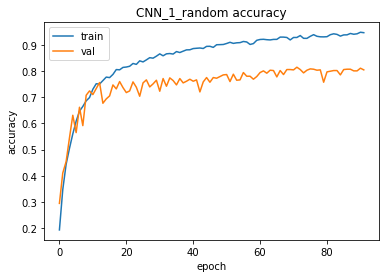

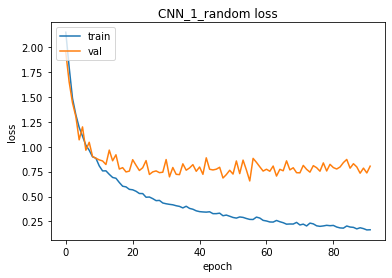

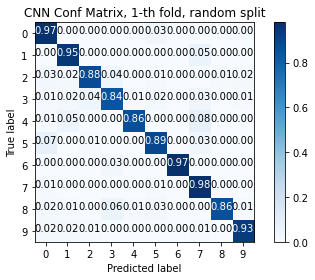

Epoch 1/100
56/56 [==============================] - 113s 2s/step - loss: 2.2017 - accuracy: 0.1467 - val_loss: 1.9270 - val_accuracy: 0.3053
Epoch 2/100
56/56 [==============================] - 114s 2s/step - loss: 1.8834 - accuracy: 0.3229 - val_loss: 1.5624 - val_accuracy: 0.4402
Epoch 3/100
56/56 [==============================] - 112s 2s/step - loss: 1.5246 - accuracy: 0.4334 - val_loss: 1.3763 - val_accuracy: 0.4835
Epoch 4/100
56/56 [==============================] - 114s 2s/step - loss: 1.3429 - accuracy: 0.5027 - val_loss: 1.2259 - val_accuracy: 0.5483
Epoch 5/100
56/56 [==============================] - 113s 2s/step - loss: 1.2534 - accuracy: 0.5398 - val_loss: 1.1361 - val_accuracy: 0.6234
Epoch 6/100
56/56 [==============================] - 112s 2s/step - loss: 1.1162 - accuracy: 0.6154 - val_loss: 1.0864 - val_accuracy: 0.6260
Epoch 7/100
56/56 [==============================] - 111s 2s/step - loss: 1.0619 - accuracy: 0.6321 - val_loss: 0.9657 - val_accuracy: 0.6667
Epoch 

56/56 [==============================] - 114s 2s/step - loss: 0.2369 - accuracy: 0.9229 - val_loss: 0.6947 - val_accuracy: 0.7812
Epoch 59/100
56/56 [==============================] - 113s 2s/step - loss: 0.2409 - accuracy: 0.9216 - val_loss: 0.6320 - val_accuracy: 0.7812
Epoch 60/100
56/56 [==============================] - 114s 2s/step - loss: 0.2402 - accuracy: 0.9228 - val_loss: 0.6694 - val_accuracy: 0.7939
Epoch 61/100
56/56 [==============================] - 110s 2s/step - loss: 0.2471 - accuracy: 0.9157 - val_loss: 0.7037 - val_accuracy: 0.7850
Epoch 62/100
56/56 [==============================] - 114s 2s/step - loss: 0.2399 - accuracy: 0.9199 - val_loss: 0.7603 - val_accuracy: 0.7837
Epoch 63/100
56/56 [==============================] - 110s 2s/step - loss: 0.2327 - accuracy: 0.9223 - val_loss: 0.6721 - val_accuracy: 0.7875
Epoch 64/100
56/56 [==============================] - 112s 2s/step - loss: 0.2318 - accuracy: 0.9231 - val_loss: 0.6792 - val_accuracy: 0.7964
Epoch 65/100

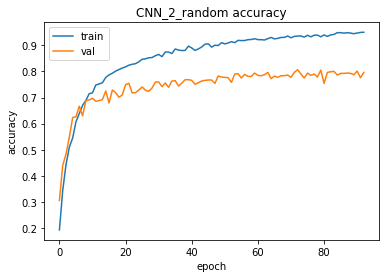

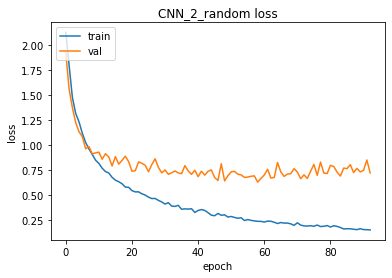

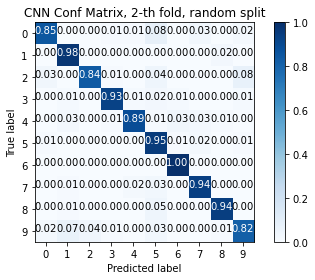

Epoch 1/100
56/56 [==============================] - 115s 2s/step - loss: 2.1954 - accuracy: 0.1688 - val_loss: 1.9214 - val_accuracy: 0.3333
Epoch 2/100
56/56 [==============================] - 112s 2s/step - loss: 1.8807 - accuracy: 0.3297 - val_loss: 1.5321 - val_accuracy: 0.4224
Epoch 3/100
56/56 [==============================] - 113s 2s/step - loss: 1.5090 - accuracy: 0.4307 - val_loss: 1.3709 - val_accuracy: 0.4847
Epoch 4/100
56/56 [==============================] - 112s 2s/step - loss: 1.3465 - accuracy: 0.4990 - val_loss: 1.2511 - val_accuracy: 0.4987
Epoch 5/100
56/56 [==============================] - 113s 2s/step - loss: 1.2395 - accuracy: 0.5336 - val_loss: 1.1972 - val_accuracy: 0.5967
Epoch 6/100
56/56 [==============================] - 113s 2s/step - loss: 1.1171 - accuracy: 0.5936 - val_loss: 1.0359 - val_accuracy: 0.6489
Epoch 7/100
56/56 [==============================] - 112s 2s/step - loss: 1.0539 - accuracy: 0.6220 - val_loss: 1.0487 - val_accuracy: 0.6069
Epoch 

56/56 [==============================] - 111s 2s/step - loss: 0.2476 - accuracy: 0.9203 - val_loss: 0.6827 - val_accuracy: 0.7824
Epoch 59/100
56/56 [==============================] - 116s 2s/step - loss: 0.2363 - accuracy: 0.9228 - val_loss: 0.6734 - val_accuracy: 0.7901
Epoch 60/100
56/56 [==============================] - 124s 2s/step - loss: 0.2470 - accuracy: 0.9173 - val_loss: 0.6533 - val_accuracy: 0.7863
Epoch 61/100
56/56 [==============================] - 126s 2s/step - loss: 0.2528 - accuracy: 0.9161 - val_loss: 0.7284 - val_accuracy: 0.7913
Epoch 62/100
56/56 [==============================] - 130s 2s/step - loss: 0.2427 - accuracy: 0.9190 - val_loss: 0.6799 - val_accuracy: 0.7926
Epoch 63/100
56/56 [==============================] - 126s 2s/step - loss: 0.2475 - accuracy: 0.9161 - val_loss: 0.7131 - val_accuracy: 0.7888
Epoch 64/100
56/56 [==============================] - 118s 2s/step - loss: 0.2280 - accuracy: 0.9271 - val_loss: 0.6647 - val_accuracy: 0.7939
Epoch 65/100

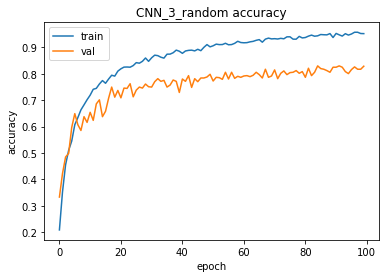

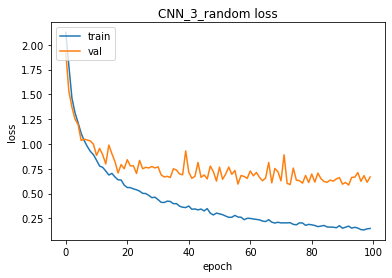

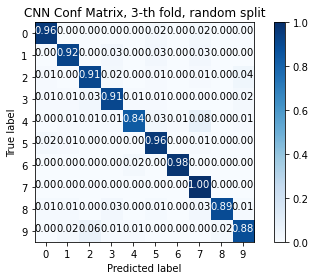

Epoch 1/100
56/56 [==============================] - 116s 2s/step - loss: 2.2090 - accuracy: 0.1639 - val_loss: 1.9150 - val_accuracy: 0.3448
Epoch 2/100
56/56 [==============================] - 117s 2s/step - loss: 1.8815 - accuracy: 0.3267 - val_loss: 1.6272 - val_accuracy: 0.4338
Epoch 3/100
56/56 [==============================] - 114s 2s/step - loss: 1.5610 - accuracy: 0.4340 - val_loss: 1.4191 - val_accuracy: 0.4491
Epoch 4/100
56/56 [==============================] - 115s 2s/step - loss: 1.3393 - accuracy: 0.4908 - val_loss: 1.1959 - val_accuracy: 0.5598
Epoch 5/100
56/56 [==============================] - 114s 2s/step - loss: 1.2026 - accuracy: 0.5594 - val_loss: 1.1405 - val_accuracy: 0.5763
Epoch 6/100
56/56 [==============================] - 116s 2s/step - loss: 1.1206 - accuracy: 0.5938 - val_loss: 1.0556 - val_accuracy: 0.6158
Epoch 7/100
56/56 [==============================] - 117s 2s/step - loss: 1.0703 - accuracy: 0.6247 - val_loss: 1.0988 - val_accuracy: 0.5840
Epoch 

56/56 [==============================] - 114s 2s/step - loss: 0.2627 - accuracy: 0.9140 - val_loss: 0.7465 - val_accuracy: 0.7812
Epoch 59/100
56/56 [==============================] - 118s 2s/step - loss: 0.2696 - accuracy: 0.9142 - val_loss: 0.8602 - val_accuracy: 0.7354
Epoch 60/100
56/56 [==============================] - 115s 2s/step - loss: 0.3329 - accuracy: 0.8904 - val_loss: 0.6812 - val_accuracy: 0.7875
Epoch 61/100
56/56 [==============================] - 113s 2s/step - loss: 0.2229 - accuracy: 0.9308 - val_loss: 0.7293 - val_accuracy: 0.7901
Epoch 62/100
56/56 [==============================] - 117s 2s/step - loss: 0.2268 - accuracy: 0.9319 - val_loss: 0.7447 - val_accuracy: 0.7875
Epoch 63/100
56/56 [==============================] - 116s 2s/step - loss: 0.2317 - accuracy: 0.9292 - val_loss: 0.7313 - val_accuracy: 0.7748
Epoch 64/100
56/56 [==============================] - 115s 2s/step - loss: 0.2263 - accuracy: 0.9272 - val_loss: 0.7681 - val_accuracy: 0.7812
Epoch 65/100

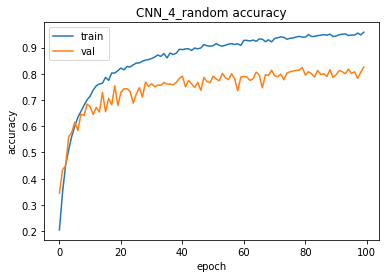

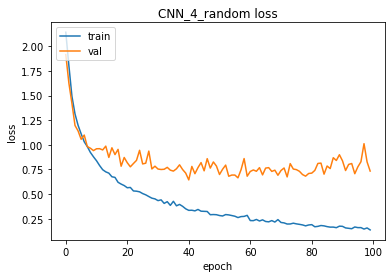

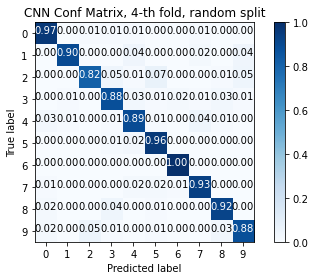

Epoch 1/100
56/56 [==============================] - 117s 2s/step - loss: 2.2054 - accuracy: 0.1595 - val_loss: 1.9383 - val_accuracy: 0.3384
Epoch 2/100
56/56 [==============================] - 118s 2s/step - loss: 1.8883 - accuracy: 0.3125 - val_loss: 1.6288 - val_accuracy: 0.4046
Epoch 3/100
56/56 [==============================] - 115s 2s/step - loss: 1.5297 - accuracy: 0.4234 - val_loss: 1.4306 - val_accuracy: 0.4987
Epoch 4/100
56/56 [==============================] - 116s 2s/step - loss: 1.3443 - accuracy: 0.4921 - val_loss: 1.2917 - val_accuracy: 0.5165
Epoch 5/100
56/56 [==============================] - 116s 2s/step - loss: 1.2227 - accuracy: 0.5408 - val_loss: 1.2086 - val_accuracy: 0.5814
Epoch 6/100
56/56 [==============================] - 116s 2s/step - loss: 1.1475 - accuracy: 0.5948 - val_loss: 1.0543 - val_accuracy: 0.6336
Epoch 7/100
56/56 [==============================] - 116s 2s/step - loss: 1.1233 - accuracy: 0.6071 - val_loss: 1.0163 - val_accuracy: 0.6094
Epoch 

56/56 [==============================] - 119s 2s/step - loss: 0.2683 - accuracy: 0.9081 - val_loss: 0.7341 - val_accuracy: 0.7863
Epoch 59/100
56/56 [==============================] - 119s 2s/step - loss: 0.2517 - accuracy: 0.9186 - val_loss: 0.6448 - val_accuracy: 0.8104
Epoch 60/100
56/56 [==============================] - 116s 2s/step - loss: 0.2653 - accuracy: 0.9163 - val_loss: 0.6776 - val_accuracy: 0.7863
Epoch 61/100
56/56 [==============================] - 120s 2s/step - loss: 0.2713 - accuracy: 0.9138 - val_loss: 0.6928 - val_accuracy: 0.7964
Epoch 62/100
56/56 [==============================] - 120s 2s/step - loss: 0.2357 - accuracy: 0.9187 - val_loss: 0.6850 - val_accuracy: 0.7913
Epoch 63/100
56/56 [==============================] - 115s 2s/step - loss: 0.2354 - accuracy: 0.9257 - val_loss: 0.6276 - val_accuracy: 0.8003
Epoch 64/100
56/56 [==============================] - 117s 2s/step - loss: 0.2383 - accuracy: 0.9217 - val_loss: 0.6694 - val_accuracy: 0.8092
Epoch 65/100

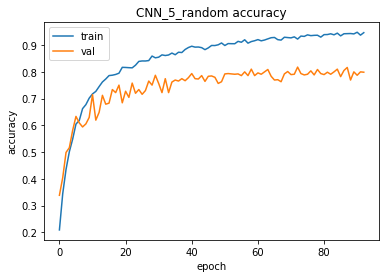

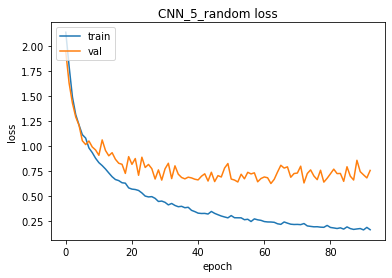

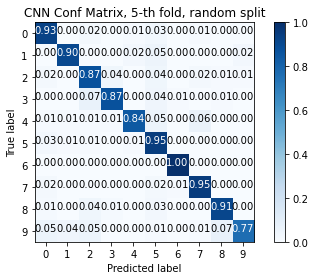

Epoch 1/100
56/56 [==============================] - 116s 2s/step - loss: 2.1966 - accuracy: 0.1485 - val_loss: 1.9216 - val_accuracy: 0.3982
Epoch 2/100
56/56 [==============================] - 116s 2s/step - loss: 1.8542 - accuracy: 0.3423 - val_loss: 1.6183 - val_accuracy: 0.3944
Epoch 3/100
56/56 [==============================] - 116s 2s/step - loss: 1.5541 - accuracy: 0.4318 - val_loss: 1.5057 - val_accuracy: 0.4593
Epoch 4/100
56/56 [==============================] - 115s 2s/step - loss: 1.3415 - accuracy: 0.5086 - val_loss: 1.2878 - val_accuracy: 0.5127
Epoch 5/100
56/56 [==============================] - 115s 2s/step - loss: 1.2337 - accuracy: 0.5484 - val_loss: 1.2731 - val_accuracy: 0.5356
Epoch 6/100
56/56 [==============================] - 124s 2s/step - loss: 1.1448 - accuracy: 0.5931 - val_loss: 1.0372 - val_accuracy: 0.6476
Epoch 7/100
56/56 [==============================] - 116s 2s/step - loss: 1.0714 - accuracy: 0.6284 - val_loss: 0.9985 - val_accuracy: 0.6539
Epoch 

56/56 [==============================] - 142s 3s/step - loss: 0.2849 - accuracy: 0.9039 - val_loss: 0.7672 - val_accuracy: 0.7748
Epoch 59/100
56/56 [==============================] - 145s 3s/step - loss: 0.2687 - accuracy: 0.9126 - val_loss: 0.7533 - val_accuracy: 0.7748
Epoch 60/100
56/56 [==============================] - 139s 2s/step - loss: 0.2527 - accuracy: 0.9163 - val_loss: 0.7563 - val_accuracy: 0.7799
Epoch 61/100
56/56 [==============================] - 139s 2s/step - loss: 0.2287 - accuracy: 0.9275 - val_loss: 0.7478 - val_accuracy: 0.7939
Epoch 62/100
56/56 [==============================] - 142s 3s/step - loss: 0.2421 - accuracy: 0.9172 - val_loss: 0.8714 - val_accuracy: 0.7468
Epoch 63/100
56/56 [==============================] - 138s 2s/step - loss: 0.2347 - accuracy: 0.9238 - val_loss: 0.6408 - val_accuracy: 0.7901
Epoch 64/100
56/56 [==============================] - 139s 2s/step - loss: 0.2228 - accuracy: 0.9279 - val_loss: 0.7696 - val_accuracy: 0.7672
Epoch 65/100

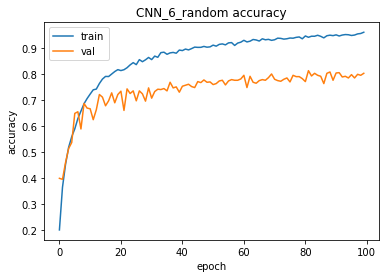

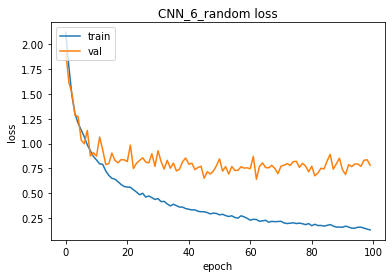

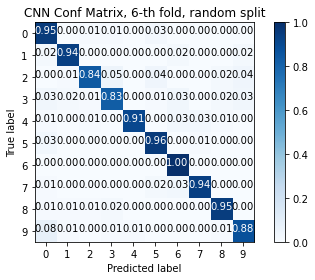

Epoch 1/100
56/56 [==============================] - 145s 3s/step - loss: 2.2027 - accuracy: 0.1545 - val_loss: 1.9449 - val_accuracy: 0.3740
Epoch 2/100
56/56 [==============================] - 144s 3s/step - loss: 1.8926 - accuracy: 0.3223 - val_loss: 1.6046 - val_accuracy: 0.3715
Epoch 3/100
56/56 [==============================] - 144s 3s/step - loss: 1.5489 - accuracy: 0.4129 - val_loss: 1.4823 - val_accuracy: 0.4160
Epoch 4/100
56/56 [==============================] - 143s 3s/step - loss: 1.4036 - accuracy: 0.4656 - val_loss: 1.2273 - val_accuracy: 0.5560
Epoch 5/100
56/56 [==============================] - 145s 3s/step - loss: 1.2649 - accuracy: 0.5260 - val_loss: 1.0969 - val_accuracy: 0.6031
Epoch 6/100
56/56 [==============================] - 145s 3s/step - loss: 1.1485 - accuracy: 0.5791 - val_loss: 1.1031 - val_accuracy: 0.5878
Epoch 7/100
56/56 [==============================] - 147s 3s/step - loss: 1.0371 - accuracy: 0.6273 - val_loss: 1.0022 - val_accuracy: 0.6361
Epoch 

56/56 [==============================] - 117s 2s/step - loss: 0.2614 - accuracy: 0.9137 - val_loss: 0.8220 - val_accuracy: 0.7672
Epoch 59/100
56/56 [==============================] - 121s 2s/step - loss: 0.2696 - accuracy: 0.9092 - val_loss: 0.7281 - val_accuracy: 0.7748
Epoch 60/100
56/56 [==============================] - 119s 2s/step - loss: 0.2732 - accuracy: 0.9126 - val_loss: 0.6640 - val_accuracy: 0.7837
Epoch 61/100
56/56 [==============================] - 121s 2s/step - loss: 0.2778 - accuracy: 0.9062 - val_loss: 0.7070 - val_accuracy: 0.7799
Epoch 62/100
56/56 [==============================] - 120s 2s/step - loss: 0.2417 - accuracy: 0.9241 - val_loss: 0.7951 - val_accuracy: 0.7634
Epoch 63/100
56/56 [==============================] - 122s 2s/step - loss: 0.2525 - accuracy: 0.9169 - val_loss: 0.7000 - val_accuracy: 0.7799
Epoch 64/100
56/56 [==============================] - 117s 2s/step - loss: 0.2336 - accuracy: 0.9269 - val_loss: 0.7290 - val_accuracy: 0.7799
Epoch 65/100

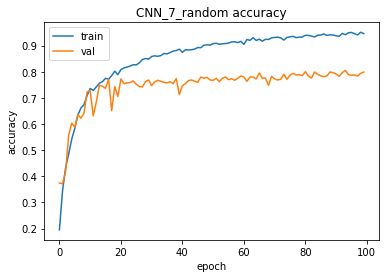

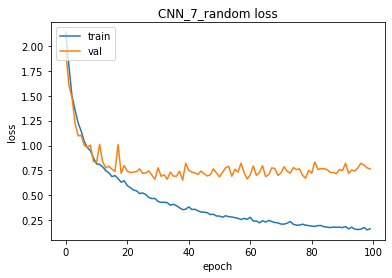

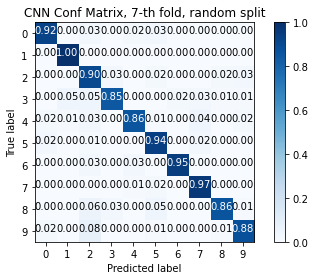

Epoch 1/100
56/56 [==============================] - 119s 2s/step - loss: 2.1897 - accuracy: 0.1704 - val_loss: 1.9021 - val_accuracy: 0.3715
Epoch 2/100
56/56 [==============================] - 115s 2s/step - loss: 1.8235 - accuracy: 0.3487 - val_loss: 1.6847 - val_accuracy: 0.3982
Epoch 3/100
56/56 [==============================] - 114s 2s/step - loss: 1.5070 - accuracy: 0.4306 - val_loss: 1.3579 - val_accuracy: 0.4809
Epoch 4/100
56/56 [==============================] - 118s 2s/step - loss: 1.3326 - accuracy: 0.4983 - val_loss: 1.2410 - val_accuracy: 0.5458
Epoch 5/100
56/56 [==============================] - 118s 2s/step - loss: 1.2324 - accuracy: 0.5355 - val_loss: 1.1997 - val_accuracy: 0.5865
Epoch 6/100
56/56 [==============================] - 114s 2s/step - loss: 1.1437 - accuracy: 0.5963 - val_loss: 1.0419 - val_accuracy: 0.6323
Epoch 7/100
56/56 [==============================] - 119s 2s/step - loss: 1.0422 - accuracy: 0.6426 - val_loss: 1.0182 - val_accuracy: 0.6272
Epoch 

56/56 [==============================] - 116s 2s/step - loss: 0.2710 - accuracy: 0.9084 - val_loss: 0.7231 - val_accuracy: 0.7812
Epoch 59/100
56/56 [==============================] - 116s 2s/step - loss: 0.2319 - accuracy: 0.9275 - val_loss: 0.7614 - val_accuracy: 0.7888
Epoch 60/100
56/56 [==============================] - 117s 2s/step - loss: 0.2294 - accuracy: 0.9283 - val_loss: 0.7817 - val_accuracy: 0.7913
Epoch 61/100
56/56 [==============================] - 116s 2s/step - loss: 0.2560 - accuracy: 0.9143 - val_loss: 0.8246 - val_accuracy: 0.7824
Epoch 62/100
56/56 [==============================] - 117s 2s/step - loss: 0.2372 - accuracy: 0.9192 - val_loss: 0.8829 - val_accuracy: 0.7519
Epoch 63/100
56/56 [==============================] - 116s 2s/step - loss: 0.2612 - accuracy: 0.9121 - val_loss: 0.8349 - val_accuracy: 0.7850
Epoch 64/100
56/56 [==============================] - 115s 2s/step - loss: 0.2184 - accuracy: 0.9273 - val_loss: 0.7329 - val_accuracy: 0.7812
Epoch 65/100

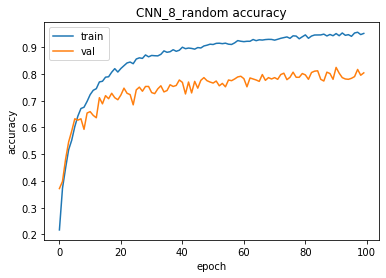

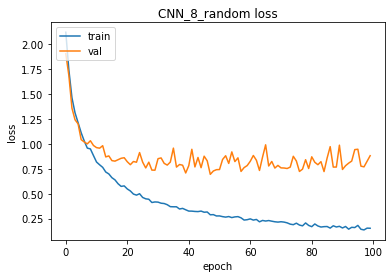

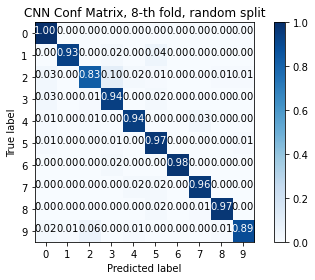

Epoch 1/100
56/56 [==============================] - 118s 2s/step - loss: 2.2071 - accuracy: 0.1574 - val_loss: 1.9194 - val_accuracy: 0.3410
Epoch 2/100
56/56 [==============================] - 115s 2s/step - loss: 1.8831 - accuracy: 0.3244 - val_loss: 1.5590 - val_accuracy: 0.4046
Epoch 3/100
56/56 [==============================] - 118s 2s/step - loss: 1.5461 - accuracy: 0.4176 - val_loss: 1.5233 - val_accuracy: 0.4249
Epoch 4/100
56/56 [==============================] - 116s 2s/step - loss: 1.3586 - accuracy: 0.4858 - val_loss: 1.2396 - val_accuracy: 0.5369
Epoch 5/100
56/56 [==============================] - 116s 2s/step - loss: 1.2684 - accuracy: 0.5344 - val_loss: 1.1773 - val_accuracy: 0.5929
Epoch 6/100
56/56 [==============================] - 118s 2s/step - loss: 1.1534 - accuracy: 0.5917 - val_loss: 1.1119 - val_accuracy: 0.6158
Epoch 7/100
56/56 [==============================] - 116s 2s/step - loss: 1.0737 - accuracy: 0.6272 - val_loss: 1.0301 - val_accuracy: 0.6043
Epoch 

56/56 [==============================] - 118s 2s/step - loss: 0.2953 - accuracy: 0.9009 - val_loss: 0.7677 - val_accuracy: 0.7875
Epoch 59/100
56/56 [==============================] - 116s 2s/step - loss: 0.2910 - accuracy: 0.9052 - val_loss: 0.7166 - val_accuracy: 0.7964
Epoch 60/100
56/56 [==============================] - 118s 2s/step - loss: 0.2432 - accuracy: 0.9222 - val_loss: 0.7472 - val_accuracy: 0.7799
Epoch 61/100
56/56 [==============================] - 113s 2s/step - loss: 0.2846 - accuracy: 0.9091 - val_loss: 0.6506 - val_accuracy: 0.8130
Epoch 62/100
56/56 [==============================] - 116s 2s/step - loss: 0.2578 - accuracy: 0.9171 - val_loss: 0.8345 - val_accuracy: 0.7786
Epoch 63/100
56/56 [==============================] - 117s 2s/step - loss: 0.2459 - accuracy: 0.9229 - val_loss: 0.8167 - val_accuracy: 0.7850
Epoch 64/100
56/56 [==============================] - 118s 2s/step - loss: 0.2473 - accuracy: 0.9173 - val_loss: 0.7245 - val_accuracy: 0.7850
Epoch 65/100

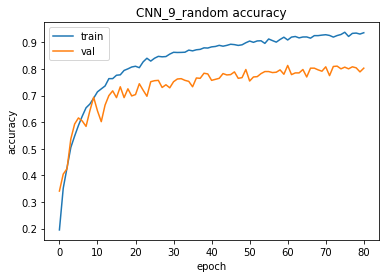

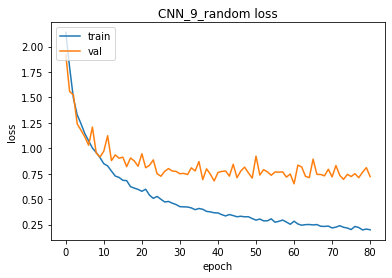

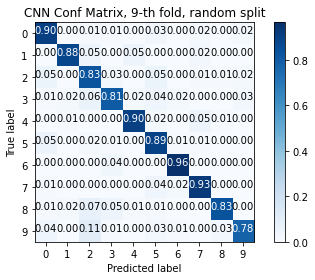

KeyError: 10

In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

epochs = 100
batch_size = 128
val_split = 0.1
verbose = 1

folds_results = {"accuracy":[], "val_accuracy":[], "test_accuracy":[], "loss":[], "val_loss":[], "test_loss":[]}

for k in range(1, 11):
    
    X_train = data[indices[k]["train"]]
    Y_train = labels[indices[k]["train"]]

    X_test = data[indices[k]["test"]]
    Y_test = labels[indices[k]["test"]]

    tf.keras.backend.clear_session()
    early_stopping = EarlyStopping(monitor="val_accuracy", patience=20)
    checkpoint = ModelCheckpoint(filepath="model_weights/cnn_"+str(k)+".hdf5", monitor="val_accuracy", verbose=0, save_best_only=True, save_weights_only=True)

    cnn = build_model(layers_list, first_time=(True if k==1 else False))
    cnn.load_weights("model_weights/cnn_starting_weights.h5")
    history = cnn.fit(x=X_train, y=Y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=val_split, verbose=verbose, callbacks=[early_stopping, checkpoint])


    best_epoch_index = np.argmax(history.history["val_accuracy"])

    folds_results["accuracy"].append(history.history["accuracy"][best_epoch_index])
    folds_results["val_accuracy"].append(history.history["val_accuracy"][best_epoch_index])
    folds_results["loss"].append(history.history["loss"][best_epoch_index])
    folds_results["val_loss"].append(history.history["val_loss"][best_epoch_index])

    cnn.load_weights("model_weights/cnn_"+str(k)+".hdf5")
    test_loss, test_accuracy = cnn.evaluate(X_test, Y_test, batch_size, verbose=0)
    folds_results["test_accuracy"].append(test_accuracy)
    folds_results["test_loss"].append(test_loss)

    plot_and_print(history, test_loss, test_accuracy, best_epoch_index, "CNN_"+str(k)+"_random")
    
    
    true = np.array([int(np.argmax(label)) for label in Y_test])
    predicted = np.array([int(np.argmax(prediction)) for prediction in cnn.predict(X_test, batch_size=batch_size)])
    cnn_cm = confusion_matrix(true, predicted, labels=np.arange(10))
    plot_confusion_matrix(cnn_cm, classes=range(10), normalize=True, title="CNN Conf Matrix, "+str(k)+"-th fold, random split", path="cm_cnn_"+str(k)+"_random.png")


We forgot to run the first split, thus we do it below. CNNs are slow to train, thus we will re-introduce this computation in the loop above, but it won't change much in terms of results, it's just about the visualizing.

Epoch 1/100
56/56 [==============================] - 85s 2s/step - loss: 2.1929 - accuracy: 0.1657 - val_loss: 1.8875 - val_accuracy: 0.4326
Epoch 2/100
56/56 [==============================] - 98s 2s/step - loss: 1.8415 - accuracy: 0.3533 - val_loss: 1.4981 - val_accuracy: 0.4593
Epoch 3/100
56/56 [==============================] - 139s 2s/step - loss: 1.4984 - accuracy: 0.4411 - val_loss: 1.3861 - val_accuracy: 0.4631
Epoch 4/100
56/56 [==============================] - 150s 3s/step - loss: 1.3333 - accuracy: 0.4901 - val_loss: 1.1804 - val_accuracy: 0.5674
Epoch 5/100
56/56 [==============================] - 148s 3s/step - loss: 1.2201 - accuracy: 0.5412 - val_loss: 1.1724 - val_accuracy: 0.5725
Epoch 6/100
56/56 [==============================] - 151s 3s/step - loss: 1.1280 - accuracy: 0.5844 - val_loss: 1.0771 - val_accuracy: 0.6056
Epoch 7/100
56/56 [==============================] - 143s 3s/step - loss: 1.0494 - accuracy: 0.6244 - val_loss: 0.9743 - val_accuracy: 0.6361
Epoch 8/

56/56 [==============================] - 120s 2s/step - loss: 0.2687 - accuracy: 0.9137 - val_loss: 0.7244 - val_accuracy: 0.7850
Epoch 59/100
56/56 [==============================] - 121s 2s/step - loss: 0.2494 - accuracy: 0.9198 - val_loss: 0.9650 - val_accuracy: 0.7583
Epoch 60/100
56/56 [==============================] - 123s 2s/step - loss: 0.3013 - accuracy: 0.8955 - val_loss: 0.8591 - val_accuracy: 0.7455
Epoch 61/100
56/56 [==============================] - 122s 2s/step - loss: 0.3048 - accuracy: 0.9053 - val_loss: 0.7017 - val_accuracy: 0.7990
Epoch 62/100
56/56 [==============================] - 122s 2s/step - loss: 0.2519 - accuracy: 0.9164 - val_loss: 0.7163 - val_accuracy: 0.7977
Epoch 63/100
56/56 [==============================] - 122s 2s/step - loss: 0.3213 - accuracy: 0.8933 - val_loss: 0.7864 - val_accuracy: 0.7926
Epoch 64/100
56/56 [==============================] - 122s 2s/step - loss: 0.2548 - accuracy: 0.9181 - val_loss: 0.6937 - val_accuracy: 0.7939
Epoch 65/100

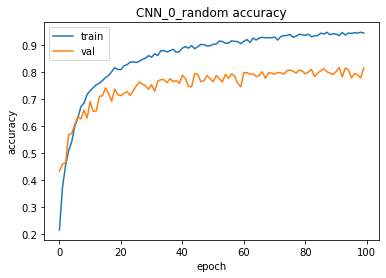

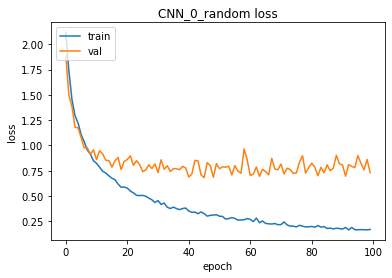

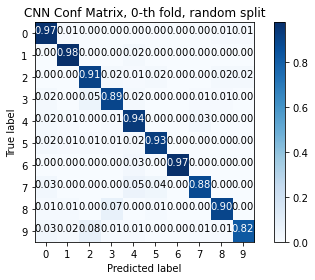

In [52]:
k = 0

X_train = data[indices[k]["train"]]
Y_train = labels[indices[k]["train"]]

X_test = data[indices[k]["test"]]
Y_test = labels[indices[k]["test"]]

tf.keras.backend.clear_session()
early_stopping = EarlyStopping(monitor="val_accuracy", patience=20)
checkpoint = ModelCheckpoint(filepath="model_weights/cnn_"+str(k)+".hdf5", monitor="val_accuracy", verbose=0, save_best_only=True, save_weights_only=True)

cnn = build_model(layers_list, first_time=(True if k==1 else False))
cnn.load_weights("model_weights/cnn_starting_weights.h5")
history = cnn.fit(x=X_train, y=Y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=val_split, verbose=verbose, callbacks=[early_stopping, checkpoint])


best_epoch_index = np.argmax(history.history["val_accuracy"])

folds_results["accuracy"].insert(0, history.history["accuracy"][best_epoch_index])
folds_results["val_accuracy"].insert(0, history.history["val_accuracy"][best_epoch_index])
folds_results["loss"].insert(0, history.history["loss"][best_epoch_index])
folds_results["val_loss"].insert(0, history.history["val_loss"][best_epoch_index])

cnn.load_weights("model_weights/cnn_"+str(k)+".hdf5")
test_loss, test_accuracy = cnn.evaluate(X_test, Y_test, batch_size, verbose=0)
folds_results["test_accuracy"].insert(0, test_accuracy)
folds_results["test_loss"].insert(0, test_loss)

plot_and_print(history, test_loss, test_accuracy, best_epoch_index, "CNN_"+str(k)+"_random")


true = np.array([int(np.argmax(label)) for label in Y_test])
predicted = np.array([int(np.argmax(prediction)) for prediction in cnn.predict(X_test, batch_size=batch_size)])
cnn_cm = confusion_matrix(true, predicted, labels=np.arange(10))
plot_confusion_matrix(cnn_cm, classes=range(10), normalize=True, title="CNN Conf Matrix, "+str(k)+"-th fold, random split", path="cm_cnn_"+str(k)+"_random.png")

Avg scores and deviation:

In [53]:
print(f"Avg Training Accuracy:    {round(np.mean(folds_results['accuracy']), 4)}")
print(f"Avg Validation Accuracy:  {round(np.mean(folds_results['val_accuracy']), 4)}")
print(f"Avg Test Accuracy:        {round(np.mean(folds_results['test_accuracy']), 4)}")
print(f"\nAvg Training Loss:        {round(np.mean(folds_results['loss']), 4)}")
print(f"Avg Validation Loss:      {round(np.mean(folds_results['val_loss']), 4)}")
print(f"Avg Test Loss:            {round(np.mean(folds_results['test_loss']), 4)}")

Avg Training Accuracy:    0.9365
Avg Validation Accuracy:  0.8165
Avg Test Accuracy:        0.9063

Avg Training Loss:        0.1957
Avg Validation Loss:      0.7024
Avg Test Loss:            0.3002


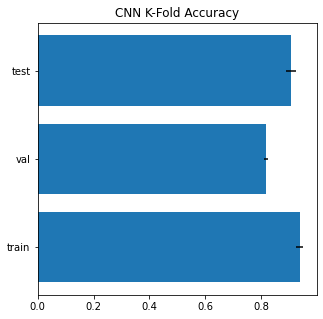

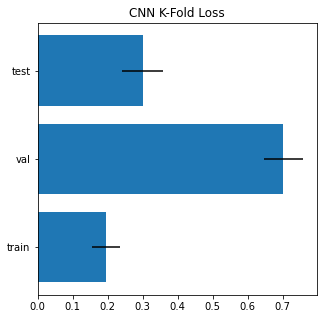

In [54]:
kfold_plots(folds_results, path="CNN")

The same loop, but now we perform it using the predefined splits.

Epoch 1/100
56/56 [==============================] - 87s 2s/step - loss: 2.1971 - accuracy: 0.1621 - val_loss: 1.8093 - val_accuracy: 0.3372
Epoch 2/100
56/56 [==============================] - 116s 2s/step - loss: 1.7239 - accuracy: 0.3711 - val_loss: 1.4118 - val_accuracy: 0.4427
Epoch 3/100
56/56 [==============================] - 113s 2s/step - loss: 1.3772 - accuracy: 0.4802 - val_loss: 1.3186 - val_accuracy: 0.4962
Epoch 4/100
56/56 [==============================] - 115s 2s/step - loss: 1.2601 - accuracy: 0.5313 - val_loss: 1.2311 - val_accuracy: 0.5229
Epoch 5/100
56/56 [==============================] - 114s 2s/step - loss: 1.1659 - accuracy: 0.5804 - val_loss: 1.1696 - val_accuracy: 0.5891
Epoch 6/100
56/56 [==============================] - 125s 2s/step - loss: 1.1129 - accuracy: 0.5978 - val_loss: 1.1296 - val_accuracy: 0.5878
Epoch 7/100
56/56 [==============================] - 112s 2s/step - loss: 1.0267 - accuracy: 0.6376 - val_loss: 1.1378 - val_accuracy: 0.5483
Epoch 8

56/56 [==============================] - 110s 2s/step - loss: 0.2855 - accuracy: 0.9041 - val_loss: 0.9302 - val_accuracy: 0.7455
Epoch 59/100
56/56 [==============================] - 112s 2s/step - loss: 0.2563 - accuracy: 0.9157 - val_loss: 0.9565 - val_accuracy: 0.7290
Epoch 60/100
56/56 [==============================] - 113s 2s/step - loss: 0.2428 - accuracy: 0.9191 - val_loss: 1.0991 - val_accuracy: 0.7239
Epoch 61/100
56/56 [==============================] - 111s 2s/step - loss: 0.2511 - accuracy: 0.9182 - val_loss: 1.0014 - val_accuracy: 0.7341
Epoch 62/100
56/56 [==============================] - 112s 2s/step - loss: 0.2300 - accuracy: 0.9285 - val_loss: 1.0422 - val_accuracy: 0.7443
Epoch 63/100
56/56 [==============================] - 113s 2s/step - loss: 0.2253 - accuracy: 0.9294 - val_loss: 0.9863 - val_accuracy: 0.7481
Epoch 64/100
56/56 [==============================] - 111s 2s/step - loss: 0.2182 - accuracy: 0.9282 - val_loss: 1.0393 - val_accuracy: 0.7468
Epoch 65/100

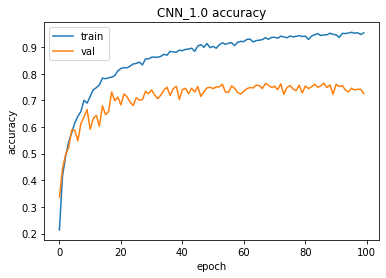

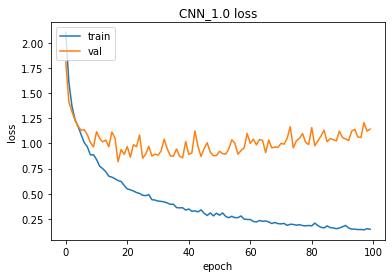

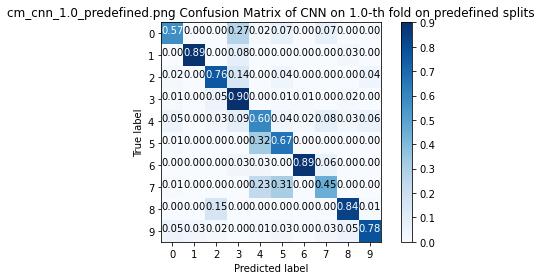

Epoch 1/100
56/56 [==============================] - 118s 2s/step - loss: 2.2082 - accuracy: 0.1507 - val_loss: 1.9116 - val_accuracy: 0.3452
Epoch 2/100
56/56 [==============================] - 112s 2s/step - loss: 1.8204 - accuracy: 0.3476 - val_loss: 1.5489 - val_accuracy: 0.4229
Epoch 3/100
56/56 [==============================] - 113s 2s/step - loss: 1.4358 - accuracy: 0.4715 - val_loss: 1.2576 - val_accuracy: 0.5516
Epoch 4/100
56/56 [==============================] - 114s 2s/step - loss: 1.2561 - accuracy: 0.5442 - val_loss: 1.3242 - val_accuracy: 0.4904
Epoch 5/100
56/56 [==============================] - 114s 2s/step - loss: 1.1941 - accuracy: 0.5642 - val_loss: 1.1877 - val_accuracy: 0.5643
Epoch 6/100
56/56 [==============================] - 114s 2s/step - loss: 1.0798 - accuracy: 0.6119 - val_loss: 1.1398 - val_accuracy: 0.5847
Epoch 7/100
56/56 [==============================] - 112s 2s/step - loss: 1.0449 - accuracy: 0.6254 - val_loss: 1.0259 - val_accuracy: 0.6217
Epoch 

56/56 [==============================] - 106s 2s/step - loss: 0.2444 - accuracy: 0.9209 - val_loss: 0.7451 - val_accuracy: 0.7771
Epoch 59/100
56/56 [==============================] - 109s 2s/step - loss: 0.2463 - accuracy: 0.9210 - val_loss: 0.9476 - val_accuracy: 0.7592
Epoch 60/100
56/56 [==============================] - 109s 2s/step - loss: 0.2617 - accuracy: 0.9128 - val_loss: 0.8045 - val_accuracy: 0.7592
Epoch 61/100
56/56 [==============================] - 106s 2s/step - loss: 0.2414 - accuracy: 0.9209 - val_loss: 0.7495 - val_accuracy: 0.7809
Epoch 62/100
56/56 [==============================] - 106s 2s/step - loss: 0.2446 - accuracy: 0.9177 - val_loss: 0.7514 - val_accuracy: 0.7860
Epoch 63/100
56/56 [==============================] - 107s 2s/step - loss: 0.2264 - accuracy: 0.9322 - val_loss: 0.9568 - val_accuracy: 0.7223
Epoch 64/100
56/56 [==============================] - 108s 2s/step - loss: 0.2355 - accuracy: 0.9220 - val_loss: 0.8632 - val_accuracy: 0.7936
Epoch 65/100

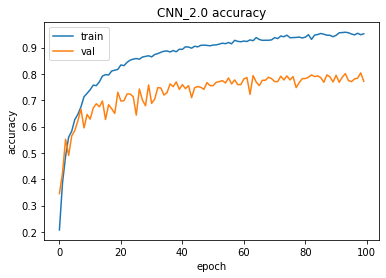

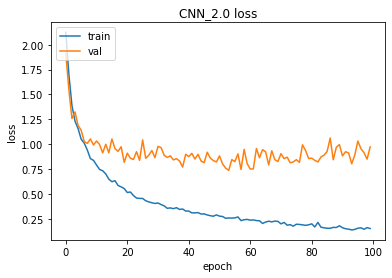

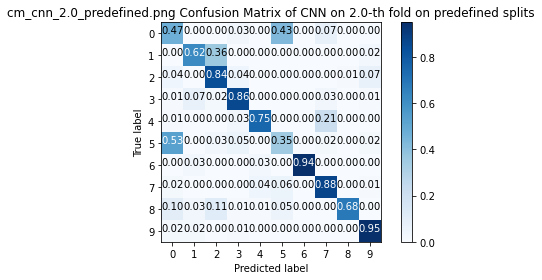

Epoch 1/100
55/55 [==============================] - 106s 2s/step - loss: 2.1984 - accuracy: 0.1572 - val_loss: 1.8343 - val_accuracy: 0.3956
Epoch 2/100
55/55 [==============================] - 107s 2s/step - loss: 1.7325 - accuracy: 0.3615 - val_loss: 1.5120 - val_accuracy: 0.4046
Epoch 3/100
55/55 [==============================] - 105s 2s/step - loss: 1.3933 - accuracy: 0.4829 - val_loss: 1.2685 - val_accuracy: 0.5723
Epoch 4/100
55/55 [==============================] - 106s 2s/step - loss: 1.2305 - accuracy: 0.5486 - val_loss: 1.2451 - val_accuracy: 0.5186
Epoch 5/100
55/55 [==============================] - 106s 2s/step - loss: 1.1128 - accuracy: 0.6072 - val_loss: 1.1288 - val_accuracy: 0.5621
Epoch 6/100
55/55 [==============================] - 106s 2s/step - loss: 1.0139 - accuracy: 0.6544 - val_loss: 1.0775 - val_accuracy: 0.6389
Epoch 7/100
55/55 [==============================] - 105s 2s/step - loss: 0.9727 - accuracy: 0.6691 - val_loss: 1.0335 - val_accuracy: 0.6684
Epoch 

55/55 [==============================] - 105s 2s/step - loss: 0.2326 - accuracy: 0.9244 - val_loss: 0.9185 - val_accuracy: 0.7759
Epoch 59/100
55/55 [==============================] - 105s 2s/step - loss: 0.2245 - accuracy: 0.9283 - val_loss: 1.0935 - val_accuracy: 0.7542
Epoch 60/100
55/55 [==============================] - 109s 2s/step - loss: 0.2291 - accuracy: 0.9253 - val_loss: 1.0134 - val_accuracy: 0.7695
Epoch 61/100
55/55 [==============================] - 106s 2s/step - loss: 0.2624 - accuracy: 0.9186 - val_loss: 0.9284 - val_accuracy: 0.7772
Epoch 62/100
55/55 [==============================] - 104s 2s/step - loss: 0.2352 - accuracy: 0.9233 - val_loss: 1.0189 - val_accuracy: 0.7695
Epoch 63/100
55/55 [==============================] - 107s 2s/step - loss: 0.2068 - accuracy: 0.9351 - val_loss: 1.0532 - val_accuracy: 0.7734
Epoch 64/100
55/55 [==============================] - 105s 2s/step - loss: 0.2130 - accuracy: 0.9285 - val_loss: 0.9926 - val_accuracy: 0.7746
Epoch 65/100

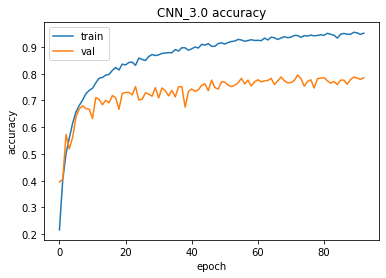

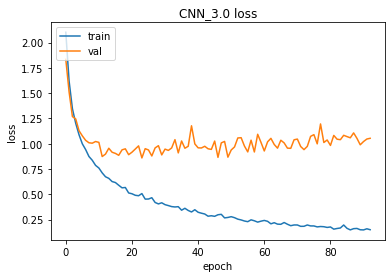

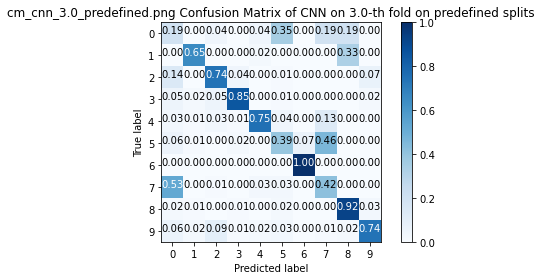

Epoch 1/100
55/55 [==============================] - 104s 2s/step - loss: 2.1931 - accuracy: 0.1650 - val_loss: 1.9099 - val_accuracy: 0.3316
Epoch 2/100
55/55 [==============================] - 105s 2s/step - loss: 1.7130 - accuracy: 0.3695 - val_loss: 1.5671 - val_accuracy: 0.4181
Epoch 3/100
55/55 [==============================] - 106s 2s/step - loss: 1.3875 - accuracy: 0.4822 - val_loss: 1.3322 - val_accuracy: 0.5458
Epoch 4/100
55/55 [==============================] - 103s 2s/step - loss: 1.2370 - accuracy: 0.5347 - val_loss: 1.2135 - val_accuracy: 0.5755
Epoch 5/100
55/55 [==============================] - 106s 2s/step - loss: 1.1804 - accuracy: 0.5708 - val_loss: 1.1318 - val_accuracy: 0.6103
Epoch 6/100
55/55 [==============================] - 102s 2s/step - loss: 1.0758 - accuracy: 0.6160 - val_loss: 1.1147 - val_accuracy: 0.5574
Epoch 7/100
55/55 [==============================] - 105s 2s/step - loss: 1.0043 - accuracy: 0.6403 - val_loss: 1.0320 - val_accuracy: 0.6348
Epoch 

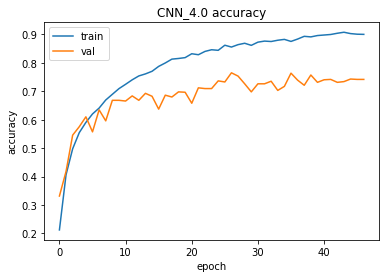

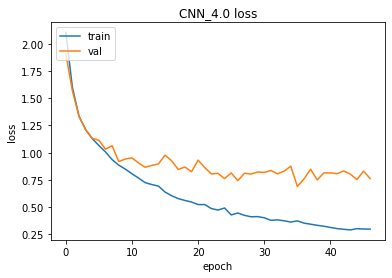

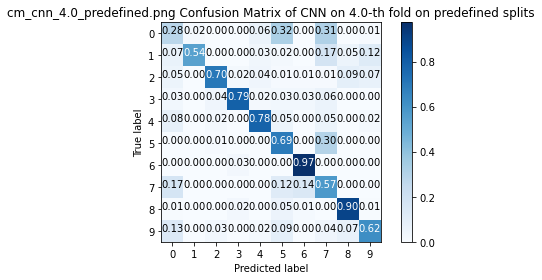

Epoch 1/100
55/55 [==============================] - 107s 2s/step - loss: 2.1931 - accuracy: 0.1596 - val_loss: 1.9097 - val_accuracy: 0.2679
Epoch 2/100
55/55 [==============================] - 103s 2s/step - loss: 1.7594 - accuracy: 0.3700 - val_loss: 1.4296 - val_accuracy: 0.4526
Epoch 3/100
55/55 [==============================] - 107s 2s/step - loss: 1.3732 - accuracy: 0.4979 - val_loss: 1.3010 - val_accuracy: 0.5167
Epoch 4/100
55/55 [==============================] - 104s 2s/step - loss: 1.2240 - accuracy: 0.5425 - val_loss: 1.2128 - val_accuracy: 0.5756
Epoch 5/100
55/55 [==============================] - 107s 2s/step - loss: 1.1560 - accuracy: 0.6052 - val_loss: 1.1544 - val_accuracy: 0.5692
Epoch 6/100
55/55 [==============================] - 105s 2s/step - loss: 1.0382 - accuracy: 0.6349 - val_loss: 1.1927 - val_accuracy: 0.5538
Epoch 7/100
55/55 [==============================] - 106s 2s/step - loss: 1.0474 - accuracy: 0.6249 - val_loss: 1.0662 - val_accuracy: 0.6244
Epoch 

55/55 [==============================] - 105s 2s/step - loss: 0.2221 - accuracy: 0.9294 - val_loss: 0.9432 - val_accuracy: 0.7526
Epoch 59/100
55/55 [==============================] - 104s 2s/step - loss: 0.2445 - accuracy: 0.9221 - val_loss: 0.8352 - val_accuracy: 0.7551
Epoch 60/100
55/55 [==============================] - 106s 2s/step - loss: 0.2363 - accuracy: 0.9237 - val_loss: 0.8879 - val_accuracy: 0.7538
Epoch 61/100
55/55 [==============================] - 105s 2s/step - loss: 0.2277 - accuracy: 0.9290 - val_loss: 0.9048 - val_accuracy: 0.7641
Epoch 62/100
55/55 [==============================] - 106s 2s/step - loss: 0.2284 - accuracy: 0.9283 - val_loss: 0.8536 - val_accuracy: 0.7474
Epoch 63/100
55/55 [==============================] - 105s 2s/step - loss: 0.2313 - accuracy: 0.9250 - val_loss: 0.9525 - val_accuracy: 0.7359
Epoch 64/100
55/55 [==============================] - 105s 2s/step - loss: 0.2331 - accuracy: 0.9266 - val_loss: 0.9017 - val_accuracy: 0.7449
Epoch 65/100

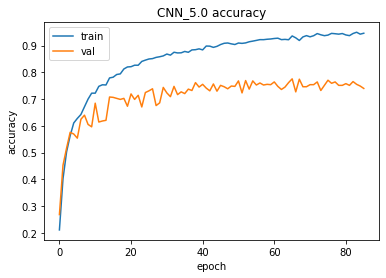

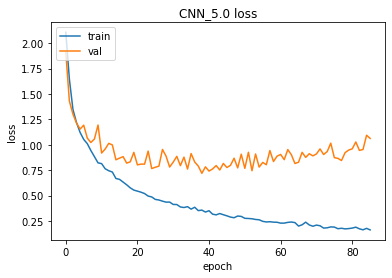

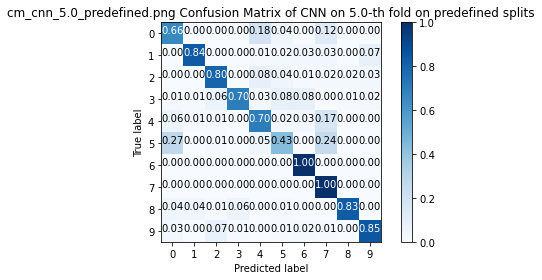

Epoch 1/100
56/56 [==============================] - 116s 2s/step - loss: 2.2049 - accuracy: 0.1565 - val_loss: 1.8729 - val_accuracy: 0.2819
Epoch 2/100
56/56 [==============================] - 119s 2s/step - loss: 1.7599 - accuracy: 0.3683 - val_loss: 1.4681 - val_accuracy: 0.4589
Epoch 3/100
56/56 [==============================] - 117s 2s/step - loss: 1.3670 - accuracy: 0.4792 - val_loss: 1.3081 - val_accuracy: 0.5032
Epoch 4/100
56/56 [==============================] - 117s 2s/step - loss: 1.2139 - accuracy: 0.5584 - val_loss: 1.2167 - val_accuracy: 0.5209
Epoch 5/100
56/56 [==============================] - 118s 2s/step - loss: 1.1452 - accuracy: 0.5914 - val_loss: 1.1820 - val_accuracy: 0.5638
Epoch 6/100
56/56 [==============================] - 115s 2s/step - loss: 1.1049 - accuracy: 0.6158 - val_loss: 1.1307 - val_accuracy: 0.5626
Epoch 7/100
56/56 [==============================] - 118s 2s/step - loss: 1.0406 - accuracy: 0.6369 - val_loss: 1.0294 - val_accuracy: 0.6397
Epoch 

56/56 [==============================] - 121s 2s/step - loss: 0.2096 - accuracy: 0.9297 - val_loss: 0.7034 - val_accuracy: 0.7977
Epoch 59/100
56/56 [==============================] - 119s 2s/step - loss: 0.2134 - accuracy: 0.9302 - val_loss: 0.7143 - val_accuracy: 0.7813
Epoch 60/100
56/56 [==============================] - 120s 2s/step - loss: 0.2246 - accuracy: 0.9290 - val_loss: 0.9022 - val_accuracy: 0.7370
Epoch 61/100
56/56 [==============================] - 118s 2s/step - loss: 0.2152 - accuracy: 0.9305 - val_loss: 0.8042 - val_accuracy: 0.7737
Epoch 62/100
56/56 [==============================] - 120s 2s/step - loss: 0.1978 - accuracy: 0.9360 - val_loss: 0.8972 - val_accuracy: 0.7674
Epoch 63/100
56/56 [==============================] - 119s 2s/step - loss: 0.2036 - accuracy: 0.9332 - val_loss: 0.7956 - val_accuracy: 0.7775
Epoch 64/100
56/56 [==============================] - 123s 2s/step - loss: 0.2331 - accuracy: 0.9233 - val_loss: 0.8293 - val_accuracy: 0.7813
Epoch 65/100

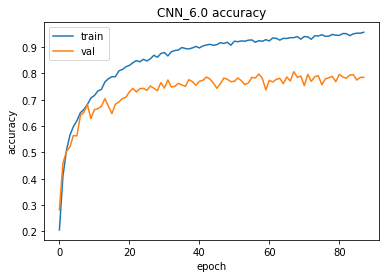

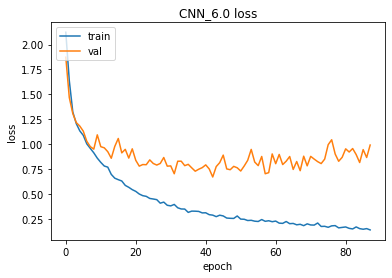

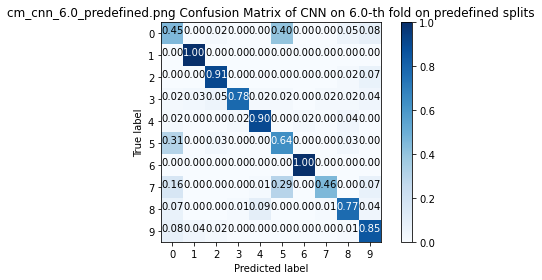

Epoch 1/100
56/56 [==============================] - 137s 2s/step - loss: 2.1838 - accuracy: 0.1611 - val_loss: 1.8686 - val_accuracy: 0.3468
Epoch 2/100
56/56 [==============================] - 134s 2s/step - loss: 1.7833 - accuracy: 0.3585 - val_loss: 1.4712 - val_accuracy: 0.4418
Epoch 3/100
56/56 [==============================] - 133s 2s/step - loss: 1.4384 - accuracy: 0.4737 - val_loss: 1.3009 - val_accuracy: 0.5228
Epoch 4/100
56/56 [==============================] - 139s 2s/step - loss: 1.2289 - accuracy: 0.5616 - val_loss: 1.2298 - val_accuracy: 0.5228
Epoch 5/100
56/56 [==============================] - 138s 2s/step - loss: 1.1354 - accuracy: 0.5960 - val_loss: 1.2201 - val_accuracy: 0.5316
Epoch 6/100
56/56 [==============================] - 135s 2s/step - loss: 1.0566 - accuracy: 0.6344 - val_loss: 1.0515 - val_accuracy: 0.5899
Epoch 7/100
56/56 [==============================] - 137s 2s/step - loss: 1.0121 - accuracy: 0.6383 - val_loss: 1.0825 - val_accuracy: 0.5962
Epoch 

56/56 [==============================] - 114s 2s/step - loss: 0.2334 - accuracy: 0.9269 - val_loss: 0.8561 - val_accuracy: 0.7582
Epoch 59/100
56/56 [==============================] - 109s 2s/step - loss: 0.2285 - accuracy: 0.9239 - val_loss: 0.9312 - val_accuracy: 0.7658
Epoch 60/100
56/56 [==============================] - 113s 2s/step - loss: 0.2529 - accuracy: 0.9171 - val_loss: 0.8759 - val_accuracy: 0.7646
Epoch 61/100
56/56 [==============================] - 117s 2s/step - loss: 0.2276 - accuracy: 0.9275 - val_loss: 0.9860 - val_accuracy: 0.7633
Epoch 62/100
56/56 [==============================] - 113s 2s/step - loss: 0.2213 - accuracy: 0.9319 - val_loss: 0.8155 - val_accuracy: 0.7835
Epoch 63/100
56/56 [==============================] - 112s 2s/step - loss: 0.2272 - accuracy: 0.9231 - val_loss: 0.9127 - val_accuracy: 0.7620
Epoch 64/100
56/56 [==============================] - 122s 2s/step - loss: 0.2146 - accuracy: 0.9316 - val_loss: 0.8536 - val_accuracy: 0.7658
Epoch 65/100

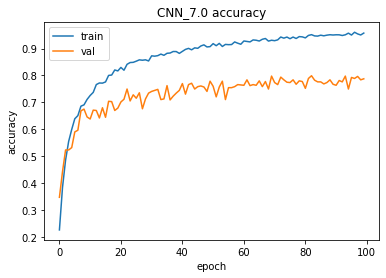

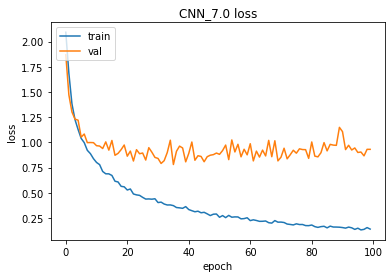

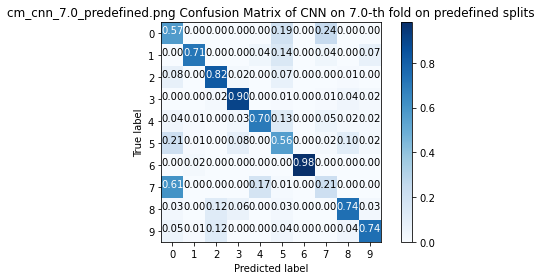

Epoch 1/100
56/56 [==============================] - 121s 2s/step - loss: 2.2123 - accuracy: 0.1538 - val_loss: 1.8288 - val_accuracy: 0.3001
Epoch 2/100
56/56 [==============================] - 125s 2s/step - loss: 1.7435 - accuracy: 0.3584 - val_loss: 1.5228 - val_accuracy: 0.4098
Epoch 3/100
56/56 [==============================] - 123s 2s/step - loss: 1.3811 - accuracy: 0.4959 - val_loss: 1.2596 - val_accuracy: 0.5271
Epoch 4/100
56/56 [==============================] - 124s 2s/step - loss: 1.2164 - accuracy: 0.5661 - val_loss: 1.3256 - val_accuracy: 0.5284
Epoch 5/100
56/56 [==============================] - 122s 2s/step - loss: 1.1316 - accuracy: 0.5974 - val_loss: 1.2146 - val_accuracy: 0.5170
Epoch 6/100
56/56 [==============================] - 125s 2s/step - loss: 1.0564 - accuracy: 0.6320 - val_loss: 1.0752 - val_accuracy: 0.5965
Epoch 7/100
56/56 [==============================] - 130s 2s/step - loss: 1.0107 - accuracy: 0.6461 - val_loss: 1.0049 - val_accuracy: 0.6217
Epoch 

56/56 [==============================] - 121s 2s/step - loss: 0.2322 - accuracy: 0.9260 - val_loss: 0.7990 - val_accuracy: 0.7768
Epoch 59/100
56/56 [==============================] - 126s 2s/step - loss: 0.2551 - accuracy: 0.9198 - val_loss: 0.8433 - val_accuracy: 0.7680
Epoch 60/100
56/56 [==============================] - 119s 2s/step - loss: 0.2461 - accuracy: 0.9228 - val_loss: 0.7587 - val_accuracy: 0.7743
Epoch 61/100
56/56 [==============================] - 117s 2s/step - loss: 0.2325 - accuracy: 0.9230 - val_loss: 0.8471 - val_accuracy: 0.7793
Epoch 62/100
56/56 [==============================] - 121s 2s/step - loss: 0.2404 - accuracy: 0.9213 - val_loss: 0.7370 - val_accuracy: 0.7705
Epoch 63/100
56/56 [==============================] - 119s 2s/step - loss: 0.2233 - accuracy: 0.9293 - val_loss: 0.8462 - val_accuracy: 0.7831
Epoch 64/100
56/56 [==============================] - 121s 2s/step - loss: 0.2284 - accuracy: 0.9281 - val_loss: 0.9184 - val_accuracy: 0.7528
Epoch 65/100

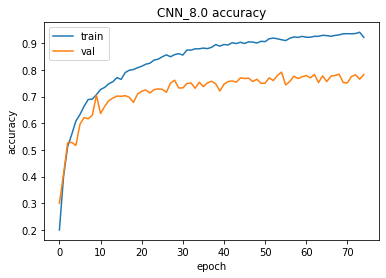

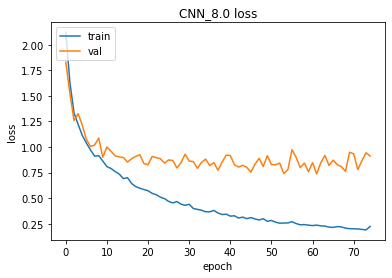

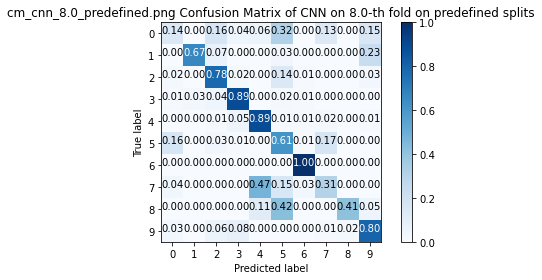

Epoch 1/100
56/56 [==============================] - 116s 2s/step - loss: 2.2257 - accuracy: 0.1314 - val_loss: 1.9457 - val_accuracy: 0.3384
Epoch 2/100
56/56 [==============================] - 116s 2s/step - loss: 1.8639 - accuracy: 0.3178 - val_loss: 1.6791 - val_accuracy: 0.3775
Epoch 3/100
56/56 [==============================] - 114s 2s/step - loss: 1.5005 - accuracy: 0.4495 - val_loss: 1.4001 - val_accuracy: 0.5215
Epoch 4/100
56/56 [==============================] - 119s 2s/step - loss: 1.3051 - accuracy: 0.5289 - val_loss: 1.3826 - val_accuracy: 0.4684
Epoch 5/100
56/56 [==============================] - 116s 2s/step - loss: 1.1902 - accuracy: 0.5651 - val_loss: 1.2887 - val_accuracy: 0.5101
Epoch 6/100
56/56 [==============================] - 117s 2s/step - loss: 1.0974 - accuracy: 0.6083 - val_loss: 1.1774 - val_accuracy: 0.5316
Epoch 7/100
56/56 [==============================] - 116s 2s/step - loss: 1.0295 - accuracy: 0.6382 - val_loss: 1.1612 - val_accuracy: 0.6098
Epoch 

56/56 [==============================] - 130s 2s/step - loss: 0.2048 - accuracy: 0.9372 - val_loss: 0.9573 - val_accuracy: 0.7702
Epoch 59/100
56/56 [==============================] - 138s 2s/step - loss: 0.2381 - accuracy: 0.9255 - val_loss: 0.8838 - val_accuracy: 0.7689
Epoch 60/100
56/56 [==============================] - 141s 3s/step - loss: 0.1888 - accuracy: 0.9416 - val_loss: 0.9002 - val_accuracy: 0.7790
Epoch 61/100
56/56 [==============================] - 132s 2s/step - loss: 0.2062 - accuracy: 0.9372 - val_loss: 0.9307 - val_accuracy: 0.7652
Epoch 62/100
56/56 [==============================] - 122s 2s/step - loss: 0.2048 - accuracy: 0.9363 - val_loss: 0.9083 - val_accuracy: 0.7753
Epoch 63/100
56/56 [==============================] - 138s 2s/step - loss: 0.1938 - accuracy: 0.9355 - val_loss: 0.8944 - val_accuracy: 0.7652
Epoch 64/100
56/56 [==============================] - 141s 3s/step - loss: 0.1874 - accuracy: 0.9372 - val_loss: 1.0104 - val_accuracy: 0.7765
Epoch 65/100

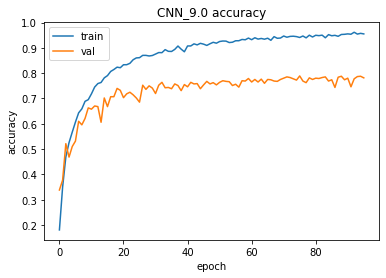

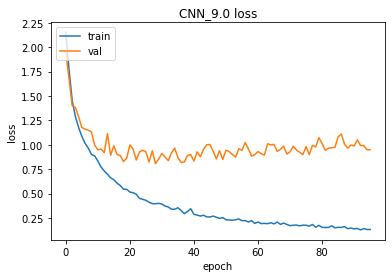

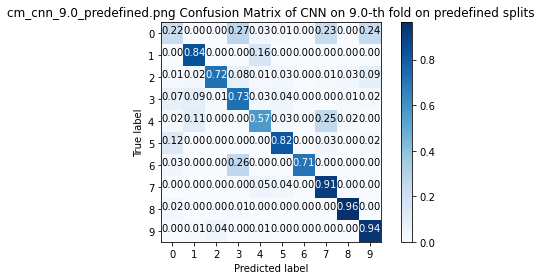

Epoch 1/100
56/56 [==============================] - 136s 2s/step - loss: 2.2216 - accuracy: 0.1525 - val_loss: 1.8627 - val_accuracy: 0.2671
Epoch 2/100
56/56 [==============================] - 137s 2s/step - loss: 1.7437 - accuracy: 0.3694 - val_loss: 1.6966 - val_accuracy: 0.3620
Epoch 3/100
56/56 [==============================] - 139s 2s/step - loss: 1.3614 - accuracy: 0.5006 - val_loss: 1.4439 - val_accuracy: 0.4532
Epoch 4/100
56/56 [==============================] - 143s 3s/step - loss: 1.2137 - accuracy: 0.5547 - val_loss: 1.4756 - val_accuracy: 0.4418
Epoch 5/100
56/56 [==============================] - 141s 3s/step - loss: 1.1426 - accuracy: 0.5818 - val_loss: 1.3838 - val_accuracy: 0.5519
Epoch 6/100
56/56 [==============================] - 142s 3s/step - loss: 1.0438 - accuracy: 0.6256 - val_loss: 1.2692 - val_accuracy: 0.5532
Epoch 7/100
56/56 [==============================] - 141s 3s/step - loss: 0.9875 - accuracy: 0.6546 - val_loss: 1.3870 - val_accuracy: 0.5380
Epoch 

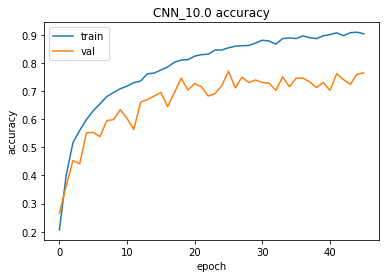

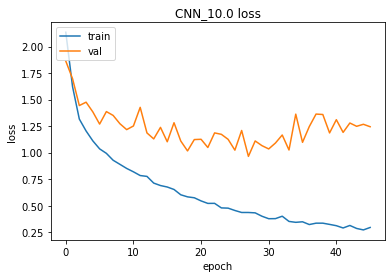

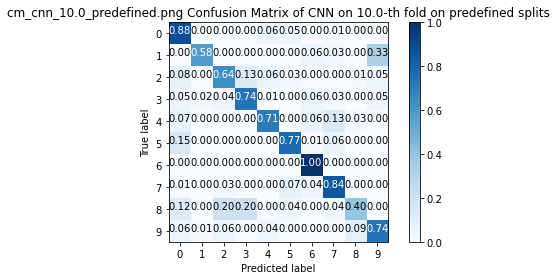

In [38]:
folds_results = {"accuracy":[], "val_accuracy":[], "test_accuracy":[], "loss":[], "val_loss":[], "test_loss":[]}

for k in np.unique(folds):
    
    X_train = data[np.where(folds!=float(k))]
    Y_train = labels[np.where(folds!=float(k))]

    X_test = data[np.where(folds==float(k))]
    Y_test = labels[np.where(folds==float(k))]

    tf.keras.backend.clear_session()
    early_stopping = EarlyStopping(monitor="val_accuracy", patience=20)
    checkpoint = ModelCheckpoint(filepath="model_weights/cnn_"+str(k)+".hdf5", monitor="val_accuracy", verbose=0, save_best_only=True, save_weights_only=True)

    cnn = build_model(layers_list, first_time=(True if k==1 else False))
    cnn.load_weights("model_weights/cnn_starting_weights.h5")
    history = cnn.fit(x=X_train, y=Y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=val_split, verbose=verbose, callbacks=[early_stopping, checkpoint])


    best_epoch_index = np.argmax(history.history["val_accuracy"])

    folds_results["accuracy"].append(history.history["accuracy"][best_epoch_index])
    folds_results["val_accuracy"].append(history.history["val_accuracy"][best_epoch_index])
    folds_results["loss"].append(history.history["loss"][best_epoch_index])
    folds_results["val_loss"].append(history.history["val_loss"][best_epoch_index])

    cnn.load_weights("model_weights/cnn_"+str(k)+".hdf5")
    test_loss, test_accuracy = cnn.evaluate(X_test, Y_test, batch_size, verbose=0)
    folds_results["test_accuracy"].append(test_accuracy)
    folds_results["test_loss"].append(test_loss)

    plot_and_print(history, test_loss, test_accuracy, best_epoch_index, "CNN_"+str(k))
    
    
    true = np.array([int(np.argmax(label)) for label in Y_test])
    predicted = np.array([int(np.argmax(prediction)) for prediction in cnn.predict(X_test, batch_size=batch_size)])
    cnn_cm = confusion_matrix(true, predicted, labels=np.arange(10))
    plot_confusion_matrix(cnn_cm, classes=range(10), normalize=True, title="Confusion Matrix of CNN on "+str(k)+"-th fold on predefined splits", path="cm_cnn_"+str(k)+"_predefined.png")

In [39]:
print(f"Avg Training Accuracy:    {round(np.mean(folds_results['accuracy']), 4)}")
print(f"Avg Validation Accuracy:  {round(np.mean(folds_results['val_accuracy']), 4)}")
print(f"Avg Test Accuracy:        {round(np.mean(folds_results['test_accuracy']), 4)}")
print(f"\nAvg Training Loss:        {round(np.mean(folds_results['loss']), 4)}")
print(f"Avg Validation Loss:      {round(np.mean(folds_results['val_loss']), 4)}")
print(f"Avg Test Loss:            {round(np.mean(folds_results['test_loss']), 4)}")

Avg Training Accuracy:    0.9225
Avg Validation Accuracy:  0.7862
Avg Test Accuracy:        0.7053

Avg Training Loss:        0.2396
Avg Validation Loss:      0.8787
Avg Test Loss:            1.3315


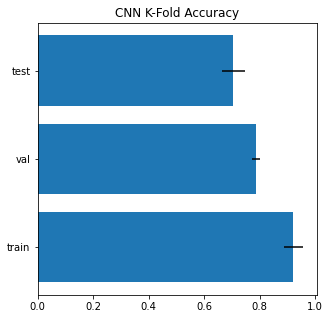

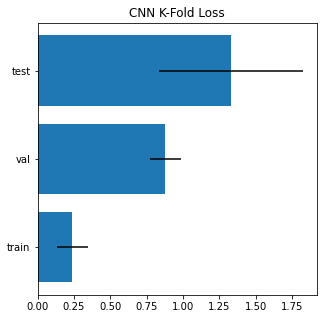

In [40]:
kfold_plots(folds_results, path="CNN")

As we can see, deep learning is not always better. Random Forests and Support Vector Machines on statistics computed on Time/Frequency domain and MFFCs/Chroma representation performed in a similar way, even better in some cases. Maybe, with bigger images together with a deeper network, or with some data augmentation the scores on the predefined splits could be increased.